In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pickle

## Camera Calibration

This is developed in camera_calibration_tune0.1


In [2]:
camera_cal = pickle.load( open( "camera_cal.p", "rb" ) )
ret = camera_cal[0]
mtx = camera_cal[1]
dist = camera_cal[2]

## Color and Gradient Thresholding

This is developed in the Pipeline_tune_0.1 notebook

In [3]:
def pipeline(img):
    
    sx_thresh=(30,75)
    s_thresh=(170, 230)
    u_thresh=(0,80)
    z_thresh=(240,255)

    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    luv = cv2.cvtColor(img, cv2.COLOR_BGR2Luv).astype(np.float)
    xyz = cv2.cvtColor(img, cv2.COLOR_BGR2XYZ).astype(np.float)

    sobel_kernel = 5

    sobelx = cv2.Sobel(hls[:,:,2], cv2.CV_64F,1,0,ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel=np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # sobelxx = cv2.Sobel(abs_sobelx, cv2.CV_64F,1,0,ksize = 3)
    # abs_sobelxx = np.absolute(sobelxx)

    #Threshold sx gradient
    sx_binary = np.zeros_like(hls[:,:,2])
    sx_binary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] =1

    #Threshold s_color channel
    s_binary = np.zeros_like(hls[:,:,2])
    s_binary[(hls[:,:,2] >= s_thresh[0]) & (hls[:,:,2] <= s_thresh[1])] = 1

    #Threshold u_color channel
    u_binary = np.zeros_like(luv[:,:,1])
    u_binary[(luv[:,:,1] >= u_thresh[0]) & (luv[:,:,1] <= u_thresh[1])] = 1

    #Threshold z_color channel
    z_binary = np.zeros_like(xyz[:,:,2])
    z_binary[(xyz[:,:,2] >= z_thresh[0]) & (xyz[:,:,2] <= z_thresh[1])] = 1


    uz_binary = np.zeros_like(xyz[:,:,2])
    uz_binary[(u_binary ==1) | (z_binary==1)]=1
    #Stach each channel
    color_binary = np.dstack((uz_binary, sx_binary, s_binary))
    
    #OR each channel
    OR_binary = np.zeros_like(xyz[:,:,2])
    OR_binary[(uz_binary ==1) | (sx_binary ==1) | (s_binary ==1)] =1
    return OR_binary

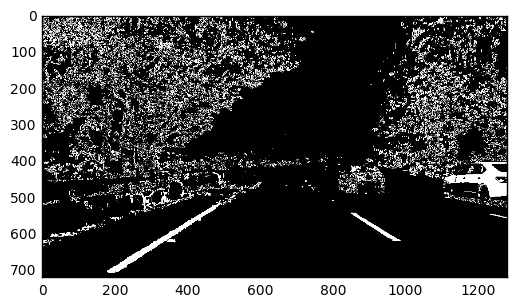

In [4]:
test_img2 = mpimg.imread('./test_images/test5.jpg')
dst = cv2.undistort(test_img2, mtx, dist, None, mtx)
res = pipeline(dst)
plt.imshow(res,cmap="bone")

# Perspective transform

Load the perspective transform that was developed in Perspective_tune_0.1.ipynb

In [5]:
#MAKE SURE THAT THE TF MATRIX WAS SAVED FOR THE PROPER IMG SIZE
pers_tf = pickle.load(open( "M_Minv.p", "rb" ) )
M = pers_tf[0]
Minv = pers_tf[1]
print(M)

[[ -4.41022051e-01  -9.46797340e-01   6.71018551e+02]
 [ -1.66533454e-16  -1.48932447e+00   6.85649282e+02]
 [  1.95156391e-18  -2.43262163e-03   1.00000000e+00]]


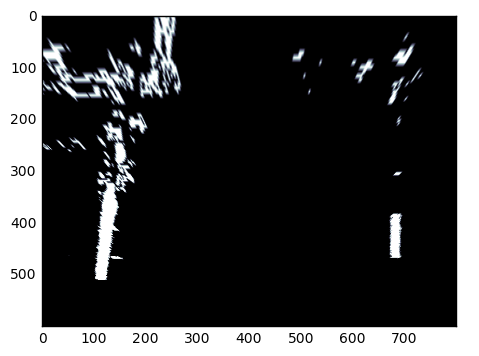

In [6]:
#perspective tf
warp_img_size = (800,600)
warped = cv2.warpPerspective(res, M, warp_img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped,cmap='bone')

## Identify lines

1. Search the entire transformed image for lines
2. If we find lines, check if their fit is reasonable
3. add their fit to the average fit / x points - increase confidence
4. If confidence > threshold, apply a mask to a region determined by the previous av fit, look for lines there
5. If confidence drops, remove the threshold


In [142]:
class Line():
    def __init__(self):
        # Is the confidence value high?
        self.locked_on = False  
        # Was the most recent frame detected
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #yvaluse for fir
        self.yvals=0
        
        #last xvals
        self.xvals=0
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
#         #x values for detected line pixels
#         self.allx = None  
#         #y values for detected line pixels
#         self.ally = None
        #iternation number RE
        self.iteration = 0
        
        self.confidence = 0
        
    def update_line(self, detect_frame=False,yv=None, fitx=None, fit=None, curverad=None):
        n=6 #moving average number
        #update iteration number
        max_confidence = 10 #of frames before the program starts looking for lines again
        thresh_confidence = 4
        

        if detect_frame == True:
            
            self.detected = True
            self.iteration = self.iteration + 1
            self.confidence = self.confidence + 1
#             print(self.confidence)
            
            if self.confidence > max_confidence:
                self.confidence = max_confidence
#             self.confidence = np.minimum(self.confidence + 1,max_confidence)
            
            if self.confidence >= thresh_confidence:
                self.locked_on = True
            
            if self.iteration ==1:
                self.best_fit = fit
                self.bestx = fitx
                self.curvature = curverad
            
            elif self.iteration > n:
            #polynomial coefficients averaged over the last n iterations
                self.best_fit = self.best_fit*(n-1.0)/n + fit*1.0/n
            
            #average x values of the fitted line over the last n iterations
                self.bestx = self.bestx*(n-1.0)/n + fitx*1.0/n
                
                self.curvature = self.curvature*(n-1.0)/n + curverad*1.0/n
            
            else:
                n2 = self.iteration
                self.best_fit = self.best_fit*(n2-1.0)/n2 + fit*1.0/n2

                self.bestx = self.bestx*(n2-1.0)/n2 + fitx*1.0/n2
                
                self.curvature = self.curvature*(n2-1.0)/n2 + curverad*1.0/n2
                
            #polynomial coefs
            self.current_fit = fit
            
            #difference in fit coefficients between last and new fits
            self.diffs = fit-self.current_fit
            self.xvals = fitx
            self.yvals = yv 
            
            #radius of curvature in meters
#             self.curvature = curverad
            
            #distance in meters of vehicle center from the line
            xm_per_pix = 3.7/550 #approximate
            self.line_base_pos = (fitx[-1]-400)*xm_per_pix 
#             print(fitx[-1])

            
            
        elif detect_frame == False:
            
            self.detected = False
            self.confidence = self.confidence - 1
            if self.confidence < 0:
                self.confidence = 0
                self.curvature = None
                self.bestx = None
                self.best_fit = None
                self.iteration = 0
            
            if self.confidence <= thresh_confidence:       
                self.locked_on = False
                
            #don't update any of the other values    
        return None


In [104]:
def draw_lines(LL, RL):
    #Use the average values from the lines
    left_fitx = LL.bestx
    right_fitx = RL.bestx
    yvals = LL.yvals
    left_lane_drawn = False
    right_lane_drawn = False
    #might have to do something if confidence is too low and bestx is not valid


    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    
    if (LL.detected == True) or (LL.locked_on ==True):
        #draw the left lane
        pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
        cv2.polylines(color_warp,np.int_([pts_left]),isClosed=False,color=(200,0,50),thickness=10)
        left_lane_drawn = True
        
    if (RL.detected == True) or (RL.locked_on ==True):
        #draw the right lane
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
        cv2.polylines(color_warp,np.int_([pts_right]),isClosed=False,color=(0,0,200),thickness=10)
        right_lane_drawn = True
    
    if (left_lane_drawn == True) and (right_lane_drawn == True):
    #Draw the polygon
        pts = np.hstack((pts_left, pts_right))
        cv2.fillPoly(color_warp, np.int_([pts]), (0,200, 200))
        
   
    return color_warp

def curvature(x_left,y_left,x_right,y_right):
    ##Find the radius of curvature
    ym_per_pix = 30.0/400 # meters per pixel in y dimension
    xm_per_pix = 3.7/550 # meteres per pixel in x dimension

    #the pixel point to evaluate the radius of curvature in the 600x800 image
    y_eval = 450

    
    left_fit_cr = np.polyfit(np.array(y_left)*ym_per_pix, np.array(x_left)*xm_per_pix, 2)
    right_fit_cr = np.polyfit(np.array(y_right)*ym_per_pix, np.array(x_right)*xm_per_pix, 2)

    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])

    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    return left_curverad,right_curverad

In [105]:
def mask_warped(warped_img,LEFT,RIGHT):
    
#If the left lane is detected in last frame, create a mask region around the line +/- X pixels from the lane up to half the image

#If the right lane is detected in last frame, create a mask region around the line +/- X pixels from the lane up to the center of the image
    
    search_pix = 30
    out_img = warped_img
    
    mask_left = np.zeros_like(warped_img)
    mask_left[:,400:-1] = 1.0 # the right side of the image is not masked
    
    mask_right = np.zeros_like(warped_img)
    mask_right[:,0:400] = 1.0 # the right side of the image is not masked
    
    if LEFT.locked_on == True: #mast the left side
        left_fitx = LEFT.bestx
        yvals = LEFT.yvals
        pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
        pts_leftA = np.array([np.transpose(np.vstack([left_fitx-search_pix, yvals]))])
        pts_leftB = np.array([np.flipud(np.transpose(np.vstack([left_fitx+search_pix, yvals])))])
        pts_leftPoly = np.hstack((pts_leftA,pts_leftB))
        cv2.fillPoly(mask_left, np.int_([pts_leftPoly]), 1.0)
        out_img = cv2.bitwise_and(out_img, mask_left)

        
    if RIGHT.locked_on == True: #mask right right side
        right_fitx = RIGHT.bestx
        yvals = RIGHT.yvals
        pts_right = np.array([np.transpose(np.vstack([right_fitx, yvals]))])
        pts_rightA = np.array([np.transpose(np.vstack([right_fitx-search_pix, yvals]))])
        pts_rightB = np.array([np.flipud(np.transpose(np.vstack([right_fitx+search_pix, yvals])))])
        pts_rightPoly = np.hstack((pts_rightA,pts_rightB))
        cv2.fillPoly(mask_right, np.int_([pts_rightPoly]), 1.0)
        out_img = cv2.bitwise_and(out_img, mask_right)
        
    return out_img
        
    

In [152]:
#Other tests why the line may not be detected adequately - run these in another function

#ideas:
#curvature is different
# abs difference of x values is big
# polynomial coeficients are different
#top or bottom of the lanes fitted lanes are too close together or too far apart

def check_lines(yv,left_fitx,right_fitx,lc,rc,LL,RL):
    left_detected = True
    right_detected = True
    
    
    left_bot = left_fitx[-1]
    right_bot = right_fitx[-1]
    left_top = left_fitx[0]
    right_top = right_fitx[0]
    
    #Some conditions that might lead to a crappy line
    
#     #if the lower ends of the line are out of place
    if (right_bot - left_bot) < 400.0 or (right_bot - left_bot) > 700.0:
        left_detected = False
        right_detected = False
        print("Fail bottom distance")
        
        
    #if the top ends of the line are out of place
    if (right_top - left_top) < 400.0 or (right_top - left_top) > 700.0:
        left_detected = False
        right_detected = False
        print("Fail top distance")
    
    if LL.iteration > 1:
        #if radius of curvature has changed more than X%
        
        prev_lc = LL.curvature
        if prev_lc:
            if (lc - prev_lc)/prev_lc > 0.2:
                left_detected = False
                print("Fail L curvature")

        prev_rc = RL.curvature
        if prev_rc:
            if (rc - prev_rc)/prev_rc > 0.2:
                right_detected = False
                print("Fail R curvature")

        #if the current x points are on average more than X % different from the best fitx pts
        #should this be MSE?
        if LL.bestx is not None:
            if np.mean(np.absolute(left_fitx - LL.bestx)/LL.bestx) > 0.2:
                left_detected = False
                print("Fail Lx")
        if RL.bestx is not None:
            if np.mean(np.absolute(right_fitx - RL.bestx)/RL.bestx) > 0.2:
                right_detected = False 
                print("Fail Rx")
    
    
    
#     left_detected = True
#     right_detected = True
    
    return left_detected, right_detected



In [136]:
def add_info(img):
    if LEFT.curvature:
        if LEFT.curvature < 5000:
            text1 = 'left curvature: '+ str(round(LEFT.curvature))
            cv2.putText(img,text1,(100,100),cv2.FONT_HERSHEY_PLAIN,2,(255,255,255),2)
        else: 
            text1 = 'left curvature: straight'
            cv2.putText(img,text1,(100,100),cv2.FONT_HERSHEY_PLAIN,2,(255,255,255),2)
    if RIGHT.curvature:
        if RIGHT.curvature < 5000:
            text2 = 'right curvature: '+ str(round(RIGHT.curvature))
            cv2.putText(img,text2,(700,100),cv2.FONT_HERSHEY_PLAIN,2,(255,255,255),2)
        else: 
            text2 = 'right curvature: straight'
            cv2.putText(img,text2,(700,100),cv2.FONT_HERSHEY_PLAIN,2,(255,255,255),2)
        
    text3 = 'Left confidence: ' + str(LEFT.confidence)
    text4 = 'Right confidence: ' + str(RIGHT.confidence)
    cv2.putText(img,text3,(100,150),cv2.FONT_HERSHEY_PLAIN,2,(255,255,255),2)
    cv2.putText(img,text4,(700,150),cv2.FONT_HERSHEY_PLAIN,2,(255,255,255),2)
    return img

In [108]:
def find_lanes(warped,dst):
    # Find the peaks
    ## warped image size is currently hardcoded
    # x: >
    # y: v

    win_y = 8 
    win_x = 20
    #detection threshold = increase probability of line detection, sensitivity to noise
    peak_thresh = 10 #threshold for detecting a peak in a single convolution line Note win_x size = 20  12/20 = 60% of pixels
    peak_thresh = peak_thresh*win_y  #threshold for detecting a peak over the y_window

    x_left = list()
    y_left = list()
    x_right = list()
    y_right = list()

    #convolution window. zeros with a ones in the center of length win_x
    window = np.zeros_like(warped[0,:])
    window[int(len(warped[0])/2-win_x/2):int(len(warped[0])/2+win_x/2)] = 1.0

    #1. mask if detected state = true
    warped = mask_warped(warped,LEFT,RIGHT)



    #iterate through the y axis of the image at win_y/2 steps, use a moving average (convolve) to find the lanes across the x axis.
    #sum these points over win_y in the y axis
    #Use a threshold for peak detection

    y_ind = win_y/2
    while y_ind < len(warped):
        #zero the conv variable
        conv=np.zeros_like(warped[0])
    #     print ('derp+', y_ind)

        #sum all the 1d convolutions around the y point of interest -win_y/2 .. + win_y/2
        for yi in range(win_y):
            ind = int(y_ind - win_y/2 + yi)
    #         print (ind)
            conv = conv + np.convolve(warped[ind,:],window,mode='same')

        #detect peaks and indices --looking for one or two peaks
        #how to differentiate left lane from right lane? - start with left side of img vs right..sucks

        if (np.max(conv[0:400])>peak_thresh):
            x_l = np.argmax(conv[0:400])
            y_l = y_ind
            x_left.append(x_l)
            y_left.append(y_l)
        if (np.max(conv[400:800])>peak_thresh):    
            x_r = (np.argmax(conv[400:800])+400)
            y_r = y_ind
            x_right.append(x_r)
            y_right.append(y_r)

        y_ind=y_ind+win_y/2


    #If we have found enough points, fit the x and y lanes for the current frame
    min_pts = 5
    if len(x_right)>min_pts and len(x_left)>min_pts:
        #Fit 2nd order polynomial to the points         
        #Using the code from the course.. because it is there
        offset = 100 #offset used in the perspective transform
        y_size = np.shape(warped)[0]#size of the warped image y axis

        yvals = np.linspace(offset, y_size-offset)

        left_fit = np.polyfit(y_left, x_left, 2)
        left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]

        right_fit = np.polyfit(y_right, x_right, 2)
        right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]

        #detect curvature
        left_curverad,right_curverad = curvature(x_left,y_left,x_right,y_right)
        # Now our radius of curvature is in meters
#         print(round(left_curverad), 'm', round(right_curverad), 'm')

        #check if the lines are reasonable
        left_detect, right_detect = check_lines(yv= yvals,left_fitx=left_fitx,right_fitx=right_fitx,lc=left_curverad,rc=right_curverad,LL=LEFT,RL=RIGHT)

        #if they are reasonable, update the Line objects for left and right lane
        LEFT.update_line(detect_frame=left_detect, yv= yvals,fitx=left_fitx,fit=left_fit,curverad=left_curverad)
        RIGHT.update_line(detect_frame=right_detect, yv= yvals,fitx=right_fitx,fit=right_fit,curverad=right_curverad)
    else:
        LEFT.update_line(detect_frame=False)
        RIGHT.update_line(detect_frame=False)

    ##Output the fitted lines in regular picture space------------------------------

    color_warp = draw_lines(LL=LEFT,RL=RIGHT)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (1280, 720))

    result = cv2.addWeighted(dst, 1, newwarp, 0.5, 0)
    
    output = add_info(result)
    
    return output

In [109]:
LEFT = Line()
RIGHT = Line()

In [110]:
def p4(test_img):
    #undistort
    dst = cv2.undistort(test_img, mtx, dist, None, mtx)
    #gradient threshold
    res = pipeline(dst)
    #perspective tf
    warp_img_size = (800,600)
    warped = cv2.warpPerspective(res, M, warp_img_size, flags=cv2.INTER_LINEAR)
    #linefit
    result = find_lanes(warped,dst)
    return (result)

In [133]:
def p4x(test_img):
    #undistort
    dst = cv2.undistort(test_img, mtx, dist, None, mtx)
    #gradient threshold
    res = pipeline(dst)
    #perspective tf
    warp_img_size = (800,600)
    warped = cv2.warpPerspective(res, M, warp_img_size, flags=cv2.INTER_LINEAR)
    #linefit
#     result = find_lanes(warped,dst)
    result = np.dstack((res, res, res))
    return (result)

In [124]:
# print(LEFT.bestx)
print(RIGHT.confidence)
print(LEFT.confidence)
print(RIGHT.locked_on)
print(LEFT.locked_on)

0
0
False
False


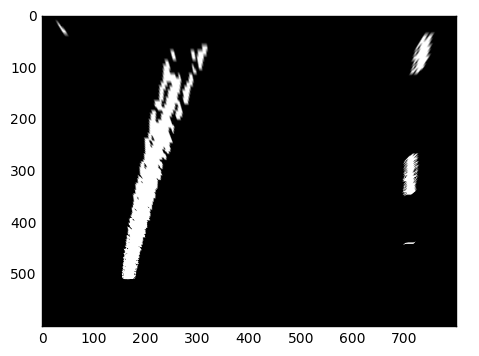

In [131]:
test_img2 = mpimg.imread('./test_images/test6.jpg')

resultx = p4x(test_img2)
plt.imshow(resultx)
# dst = cv2.undistort(test_img, mtx, dist, None, mtx)
# res = pipeline(dst)
# warp_img_size = (800,600)
# warped= cv2.warpPerspective(res, M, warp_img_size, flags=cv2.INTER_LINEAR)

In [154]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

LEFT = Line()
RIGHT = Line()

proj4_output = 'proj4.mp4'
driving_clip = VideoFileClip('project_video.mp4')
out_clip = driving_clip.fl_image(p4)
%time out_clip.write_videofile(proj4_output, audio=False)


MoviePy: building video file proj4.mp4
----------------------------------------

Writing video into proj4.mp4
|----------| 0/1210   0% [elapsed: 00:00 left: ?, ? iters/sec]

/home/robbie/anaconda3/lib/python3.5/site-packages/moviepy/audio/io/readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))


Fail R curvature
|----------| 3/1210   0% [elapsed: 00:00 left: 03:55,  5.13 iters/sec]Fail R curvature
Fail L curvature
|----------| 9/1210   0% [elapsed: 00:01 left: 03:36,  5.56 iters/sec]Fail R curvature
|----------| 12/1210   0% [elapsed: 00:02 left: 03:33,  5.60 iters/sec]Fail R curvature
|----------| 15/1210   1% [elapsed: 00:02 left: 03:33,  5.61 iters/sec]Fail R curvature
Fail L curvature
Fail R curvature
Fail R curvature
|----------| 18/1210   1% [elapsed: 00:03 left: 03:32,  5.62 iters/sec]Fail L curvature
Fail R curvature
Fail L curvature
Fail L curvature
Fail R curvature
|----------| 21/1210   1% [elapsed: 00:03 left: 03:31,  5.62 iters/sec]Fail L curvature
Fail R curvature
Fail L curvature
Fail R curvature
Fail L curvature
|----------| 24/1210   1% [elapsed: 00:04 left: 03:32,  5.59 iters/sec]Fail L curvature
Fail L curvature
Fail L curvature
|----------| 27/1210   2% [elapsed: 00:04 left: 03:31,  5.58 iters/sec]Fail L curvature
Fail L curvature
|----------| 33/1210   2% 

In [153]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

LEFT = Line()
RIGHT = Line()

proj4_output = 'test_output.mp4'
driving_clip = VideoFileClip('challenge_video.mp4')
out_clip = driving_clip.fl_image(p4)
%time out_clip.write_videofile(proj4_output, audio=False)


MoviePy: building video file test_output.mp4
----------------------------------------

Writing video into test_output.mp4
|----------| 0/388   0% [elapsed: 00:00 left: ?, ? iters/sec]

/home/robbie/anaconda3/lib/python3.5/site-packages/moviepy/audio/io/readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))


|#---------| 49/388  12% [elapsed: 00:08 left: 00:59,  5.74 iters/sec]

KeyboardInterrupt: 